In [59]:
import os 
import numpy as np 
import emcee 
import time
import pandas as pd
import matplotlib.pylab as plt 

# NUTS
from numpyro.diagnostics import summary
import jax
import jax.numpy as jnp 
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, HMC, NUTS, init_to_median
from numpyro.handlers import seed

os.makedirs('mvn', exist_ok=True)
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (8,6)
fontSize = 20

In [2]:
dimensions = np.arange(1, 11, 1, dtype = int) * 20

# Sample Multivariate Normal with EMCEE

In [3]:
def emcee_log_prob(position, mean, covariance):
    diff = position - mean
    return -0.5 * np.dot(diff, np.linalg.solve(covariance, diff))
    
def emcee_sampler(ndim, nsamples = 10000):
    mean = np.zeros(ndim)
    cov = np.eye(ndim)
    nwalkers = 2 * ndim 
    initial_1 = np.random.rand(nwalkers, ndim)
    initial_2 = np.random.rand(nwalkers, ndim)

    # we use two samplers (to compute the Gelman-Rubin statistics)
    sampler_1 = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob, args=[mean, cov])
    runsampler_1 = sampler_1.run_mcmc(initial_1, nsamples, progress = True)
    samples_1 = sampler_1.flatchain
    ap_1 = np.mean(sampler_1.acceptance_fraction)

    sampler_2 = emcee.EnsembleSampler(nwalkers, ndim, emcee_log_prob, args=[mean, cov])
    runsampler_2 = sampler_2.run_mcmc(initial_2, nsamples, progress = True)
    samples_2 = sampler_2.flatchain
    ap_2 = np.mean(sampler_2.acceptance_fraction)

    return samples_1[::nwalkers], samples_2[::nwalkers], mean, cov, ap_1, ap_2

def calculate_mean_cov(samples):
    """
    The input is of shape N x p, where N is the number of samples and p is the number of dimensions. 
    """
    sample_mean = np.mean(samples, axis = 0)
    sample_cov = np.cov(samples.T)
    return sample_mean, sample_cov

def calculate_summary(samples_1, samples_2, nlike, ndecimal = 3):
    record = []
    for i in range(samples_1.shape[1]):
        testsamples = np.vstack(([samples_1[:,i], samples_2[:,i]]))
        summary_stats = summary(testsamples)
        summary_stats[f'p_{i}'] = summary_stats.pop('Param:0')
        record.append(summary_stats)

    record_df = []
    for i in range(len(record)):
        record_df.append(pd.DataFrame(record[i]).round(ndecimal).loc[['r_hat', 'n_eff', 'mean', 'std']])

    record_df = pd.concat(record_df, axis = 1).T
    record_df['n_eff'] /= nlike
    return record_df
    
def compute_kl(mean0, mean1, cov0, cov1):
    cov1_inv = np.linalg.inv(cov1)
    ndim = cov1.shape[0]
    term1 = np.trace(cov1_inv @ cov0) - ndim 
    term2 = (mean1 - mean0) @ cov1_inv @ (mean1 - mean0)
    sign0, logdet0 = np.linalg.slogdet(cov0)
    sign1, logdet1 = np.linalg.slogdet(cov1)
    term3 = sign1 * logdet1 - sign0 * logdet0 
    return 0.5*(term1 + term2 + term3)

In [4]:
NSAMPLES = 15000
emcee_record_stats = list()
emcee_record_kl = list()
emcee_record_time = list()
emcee_record_ap = list()

for d in dimensions:

    # generate the samples 
    start_time = time.time()
    samples_1, samples_2, true_mean, true_cov, ap_1, ap_2 = emcee_sampler(d, nsamples = NSAMPLES)
    time_taken = time.time() - start_time

    # calculate sample mean and covariance
    sample_mean, sample_cov = calculate_mean_cov(np.vstack([samples_1, samples_2]))

    # calculate KL divergence
    emcee_kl = compute_kl(sample_mean, true_mean, sample_cov, true_cov)

    # record quantities 
    emcee_record_stats.append(calculate_summary(samples_1, samples_2, 2 * d * NSAMPLES))
    emcee_record_kl.append(emcee_kl)
    emcee_record_time.append(time_taken)
    emcee_record_ap.append([ap_1.item(), ap_2.item()])

    # print value of KL 
    print(f'KL-divergence is {emcee_kl:.4f}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:17<00:00, 878.20it/s]


KL-divergence is 0.7098


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:49<00:00, 301.07it/s]


KL-divergence is 6.2830


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [01:30<00:00, 165.80it/s]


KL-divergence is 23.0145


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [03:25<00:00, 73.03it/s]


KL-divergence is 50.8893


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [04:51<00:00, 51.45it/s]


KL-divergence is 84.9227


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [07:38<00:00, 32.73it/s]


KL-divergence is 131.1186


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [10:24<00:00, 24.00it/s]


KL-divergence is 174.1163


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [15:07<00:00, 16.53it/s]


KL-divergence is 230.7555


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [21:04<00:00, 11.86it/s]


KL-divergence is 279.5594


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [29:46<00:00,  8.40it/s]


KL-divergence is 338.7993


# NUTS

In [6]:
def nuts_model(ndim = 5):
    locs = jnp.zeros(ndim)
    covs = jnp.eye(ndim)
    mvn = dist.MultivariateNormal(loc = locs, covariance_matrix = covs)
    numpyro.sample('y', mvn)
    return locs, covs

In [7]:
%%capture
nuts_kernel = NUTS(nuts_model, step_size=0.1, init_strategy=init_to_median, dense_mass=True, max_tree_depth=5)
mcmc = MCMC(nuts_kernel, num_chains=2, num_warmup = 100, num_samples=15000)

In [8]:
record_nsteps = list()
nuts_record_kl = list()
nuts_record_stats = list()
nuts_record_time = list()
nuts_record_ap = list()

for d in dimensions:
    start_time = time.time()
    mcmc.run(jax.random.PRNGKey(0), ndim=d, extra_fields=('potential_energy', 'num_steps'))
    time_taken = time.time() - start_time 
    samples = np.asarray(mcmc.get_samples()['y'])
    samples_grouped = np.asarray(mcmc.get_samples(group_by_chain=True)['y'])
    nsteps = mcmc.get_extra_fields(group_by_chain=True)['num_steps']
    nevaluations = jnp.sum(nsteps).item()
    
    # calculate sample mean and covariance 
    nuts_mean, nuts_cov = calculate_mean_cov(samples)

    # calculate the KL divergence 
    nuts_kl = compute_kl(nuts_mean, np.zeros(d), nuts_cov, np.eye(d))

    # record quantities 
    nuts_record_stats.append(calculate_summary(samples_grouped[0], samples_grouped[1], nevaluations))
    record_nsteps.append(nsteps)
    nuts_record_kl.append(nuts_kl)
    nuts_record_time.append(time_taken)
    nuts_record_ap.append(mcmc.last_state.mean_accept_prob)

    # print KL divergence 
    print(f'KL-divergence is {nuts_kl:.4f}')

sample: 100%|███████████████████████████████████████████| 15100/15100 [00:55<00:00, 271.87it/s, 7 steps of size 5.81e-01. acc. prob=0.87]


KL-divergence is 0.0055


sample: 100%|██████████████████████████████████████████| 15100/15100 [02:02<00:00, 123.52it/s, 31 steps of size 4.33e-01. acc. prob=0.87]


KL-divergence is 0.0191


sample: 100%|██████████████████████████████████████████| 15100/15100 [02:11<00:00, 115.02it/s, 31 steps of size 4.03e-01. acc. prob=0.84]


KL-divergence is 0.0483


sample: 100%|██████████████████████████████████████████| 15100/15100 [02:20<00:00, 107.47it/s, 31 steps of size 2.75e-01. acc. prob=0.91]


KL-divergence is 1.4640


sample: 100%|███████████████████████████████████████████| 15100/15100 [02:32<00:00, 99.31it/s, 31 steps of size 2.49e-01. acc. prob=0.91]


KL-divergence is 6.8224


sample: 100%|███████████████████████████████████████████| 15100/15100 [02:37<00:00, 95.63it/s, 31 steps of size 2.59e-01. acc. prob=0.88]


KL-divergence is 16.8162


sample: 100%|███████████████████████████████████████████| 15100/15100 [02:46<00:00, 90.64it/s, 31 steps of size 1.81e-01. acc. prob=0.94]


KL-divergence is 30.4032


sample: 100%|███████████████████████████████████████████| 15100/15100 [02:56<00:00, 85.73it/s, 31 steps of size 2.37e-01. acc. prob=0.87]


KL-divergence is 47.6099


sample: 100%|███████████████████████████████████████████| 15100/15100 [03:06<00:00, 80.85it/s, 31 steps of size 1.66e-01. acc. prob=0.93]


KL-divergence is 74.6423


sample: 100%|███████████████████████████████████████████| 15100/15100 [03:13<00:00, 77.97it/s, 31 steps of size 1.95e-01. acc. prob=0.89]


KL-divergence is 87.8621


# Compare Results

In [9]:
def compare_stats(emcee_df, nuts_df):
    nexperiments = len(emcee_df)
    record_rhat = {'emcee': list(), 'nuts': list()}
    record_neff = {'emcee': list(), 'nuts': list()}
    for i in range(nexperiments):
        emcee_mean_stats = emcee_df[i].mean(0)
        nuts_mean_stats = nuts_df[i].mean(0)
        record_rhat['emcee'].append(emcee_mean_stats['r_hat'].item())
        record_neff['emcee'].append(emcee_mean_stats['n_eff'].item())
        record_rhat['nuts'].append(nuts_mean_stats['r_hat'].item())
        record_neff['nuts'].append(nuts_mean_stats['n_eff'].item())
    return pd.DataFrame(record_rhat, index = dimensions), pd.DataFrame(record_neff, index = dimensions)

In [14]:
df_rhat, df_neff = compare_stats(emcee_record_stats, nuts_record_stats)
df_kl = pd.DataFrame(np.vstack([emcee_record_kl, nuts_record_kl]).T, columns = ['emcee', 'nuts'], index=dimensions)
df_ap = pd.DataFrame(np.vstack([np.mean(emcee_record_ap, 1), np.mean(nuts_record_ap, 1)]).T, columns = ['emcee', 'nuts'], index=dimensions)

## Plots

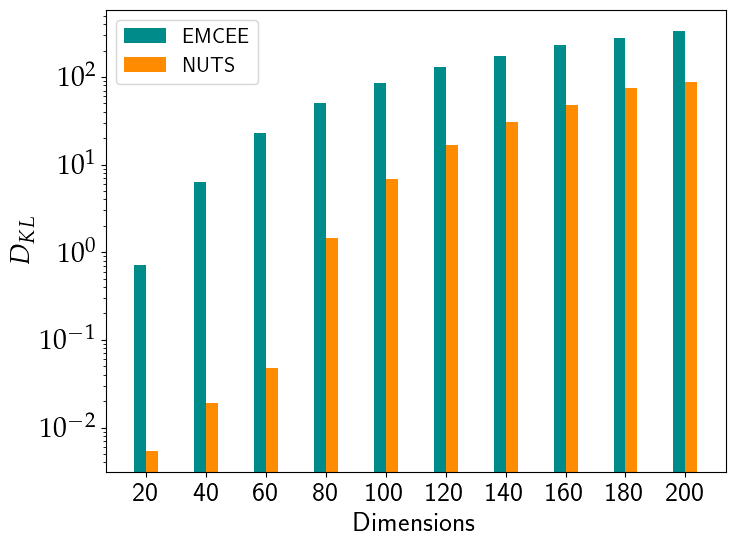

In [66]:
index = np.arange(len(dimensions))
bar_width = 0.20

fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, df_kl['emcee'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, df_kl['nuts'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$D_{KL}$', fontsize = fontSize)
# ax.set_title('KL Divergence', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
ax.set_yscale('log')
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.savefig('mvn/kl.pdf', bbox_inches = 'tight')
plt.show()

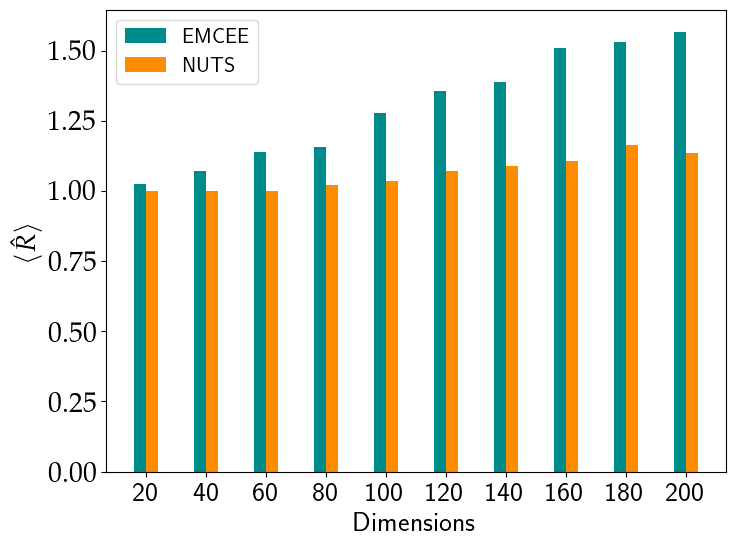

In [67]:
fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, df_rhat['emcee'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, df_rhat['nuts'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$\langle \hat{R} \rangle$', fontsize = fontSize)
# ax.set_title('Gelman-Rubin Statistics', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
# ax.set_yscale('log')
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.savefig('mvn/gr.pdf', bbox_inches = 'tight')
plt.show()

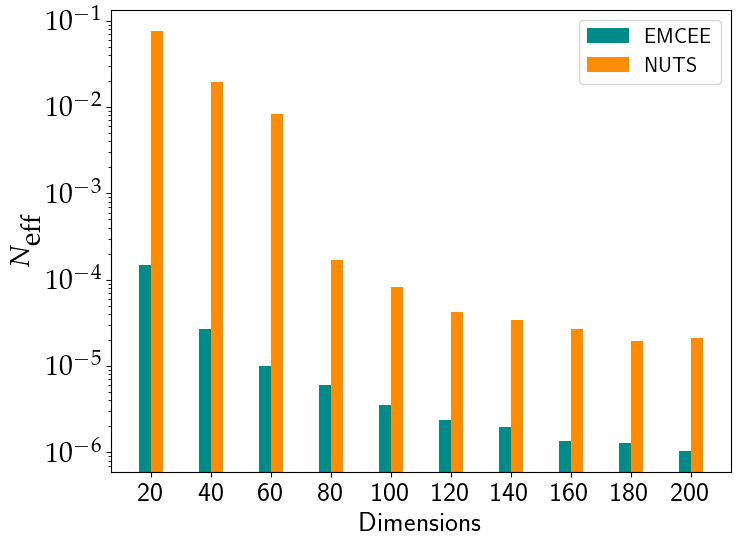

In [72]:
fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, df_neff['emcee'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, df_neff['nuts'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$N_{\textrm{eff}}$', fontsize = fontSize)
# ax.set_title('Scaled Effective Sample Size', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
ax.set_yscale('log')
ax.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.savefig('mvn/neff.pdf', bbox_inches = 'tight')
plt.show()

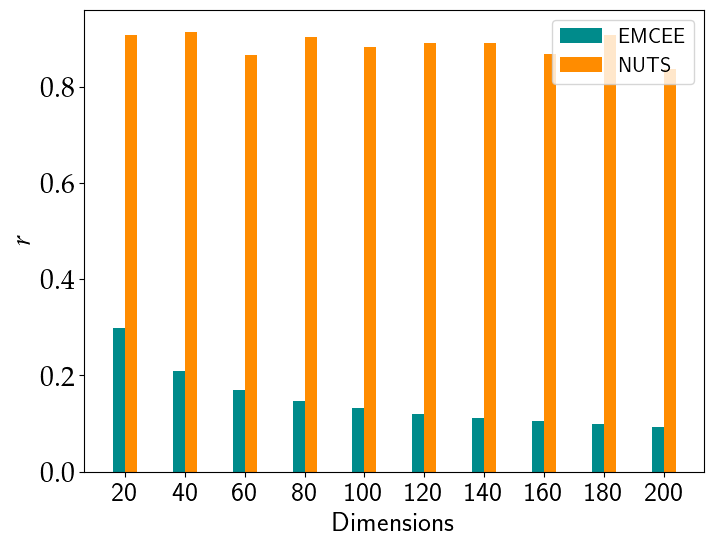

In [69]:
fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, df_ap['emcee'], bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, df_ap['nuts'], bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$r$', fontsize = fontSize)
# ax.set_title('Acceptance Probability', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
# ax.set_yscale('log')
ax.legend(loc = 'upper right',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.savefig('mvn/ap.pdf', bbox_inches = 'tight')
plt.show()

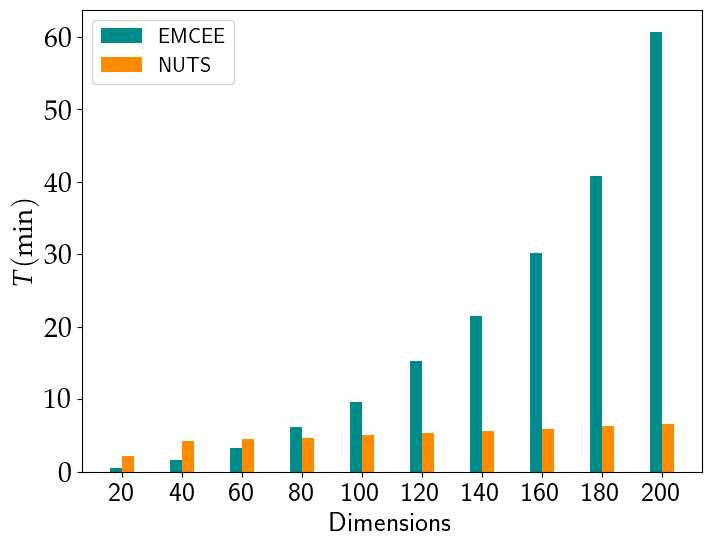

In [70]:
fig, ax = plt.subplots(figsize=figSize)
# conversion from seconds to minutes, hence factor of 60
emcee_column = ax.bar(index, np.asarray(emcee_record_time) / 60, bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, np.asarray(nuts_record_time) / 60, bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$T (\textrm{min})$', fontsize = fontSize)
# ax.set_title('Time taken (2 chains)', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
# ax.set_yscale('log')
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.savefig('mvn/time.pdf', bbox_inches = 'tight')
plt.show()

In [51]:
nuts_nlike = np.sum(record_nsteps, 2).sum(1)
emcee_nlike = np.vstack([dimensions * 2 * 15000] * 2).T.sum(1)

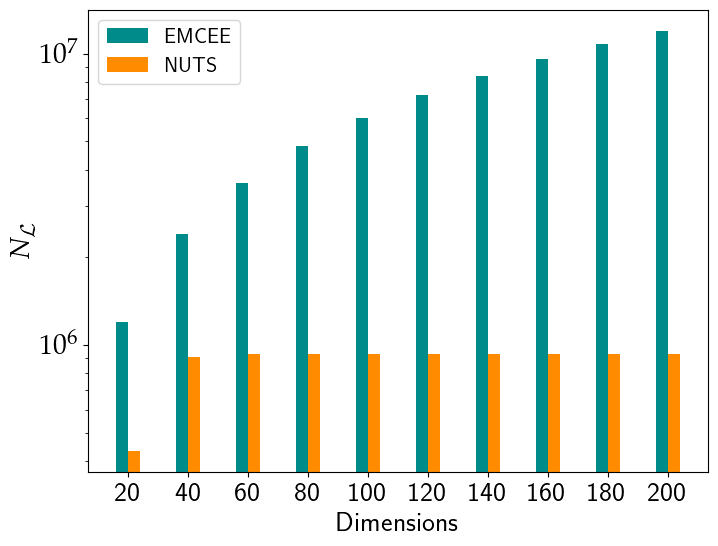

In [71]:
fig, ax = plt.subplots(figsize=figSize)
emcee_column = ax.bar(index, emcee_nlike, bar_width, label="EMCEE", color = 'darkcyan')
nuts_column = ax.bar(index+bar_width, nuts_nlike, bar_width, label="NUTS", color = 'darkorange')
ax.set_xlabel('Dimensions', fontsize = fontSize)
ax.set_ylabel(r'$N_{\mathcal{L}}$', fontsize = fontSize)
# ax.set_title('Number of likelihood evaluations (2 chains)', fontsize = fontSize)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(dimensions)
ax.set_yscale('log')
ax.legend(loc = 'upper left',prop={'family':'sans-serif', 'size':15})
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.savefig('mvn/nlike.pdf', bbox_inches = 'tight')
plt.show()